In [39]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

from vit_rollout import VITAttentionRollout
from vit_grad_rollout import VITAttentionGradRollout
from vit_flow import VITAttentionFlow

In [46]:
img = Image.open("examples/input.png")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE}")

IMAGE_SIZE = 224
DISCARD_RATIO = 0.9

def preprocess_image(image_path, transform):
    img = Image.open(image_path)
    input_tensor = transform(img).unsqueeze(0)
    return input_tensor.to(DEVICE)

def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

model = torch.hub.load('facebookresearch/deit:main', 
        'deit_tiny_patch16_224', pretrained=True)
model.eval()
model.to(DEVICE)

Using cpu


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


In [41]:
#@title Select the rollout strategy to be used and display results
#@markdown **Note** that for `grad_attention_rollout` passing a category index is mandatory.
rollout_strategy = "attention_flow" #@param ["attention_rollout", "grad_attention_rollout"]
category_index =  264#@param {type:"integer"}

print(f"Using {rollout_strategy}")

input_tensor  = preprocess_image("examples/input.png", transform)

if rollout_strategy == "grad_attention_rollout" and category_index < 0:
    raise Exception("Category index is mandatory when using Gradient Attention Rollout")

elif rollout_strategy == "grad_attention_rollout" and category_index > 0:
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=DISCARD_RATIO)
    mask = grad_rollout(input_tensor, category_index)
    name = "grad_rollout_{}_{:.3f}_{}.png".format(category_index,
        DISCARD_RATIO, "mean")

elif rollout_strategy == "attention_rollout":
    attention_rollout = VITAttentionRollout(model, discard_ratio=DISCARD_RATIO)
    mask = attention_rollout(input_tensor)
    name = "attention_rollout_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")
    
elif rollout_strategy == "attention_flow":
    attention_flow = VITAttentionFlow(model, discard_ratio=DISCARD_RATIO)
    mask = attention_flow(input_tensor)
    name = "attention_flow_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")

np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)

# mask = (mask - mask.min()) / (mask.max() - mask.min())
# mask = mask.clip(0.7,1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(mask)

Using attention_flow


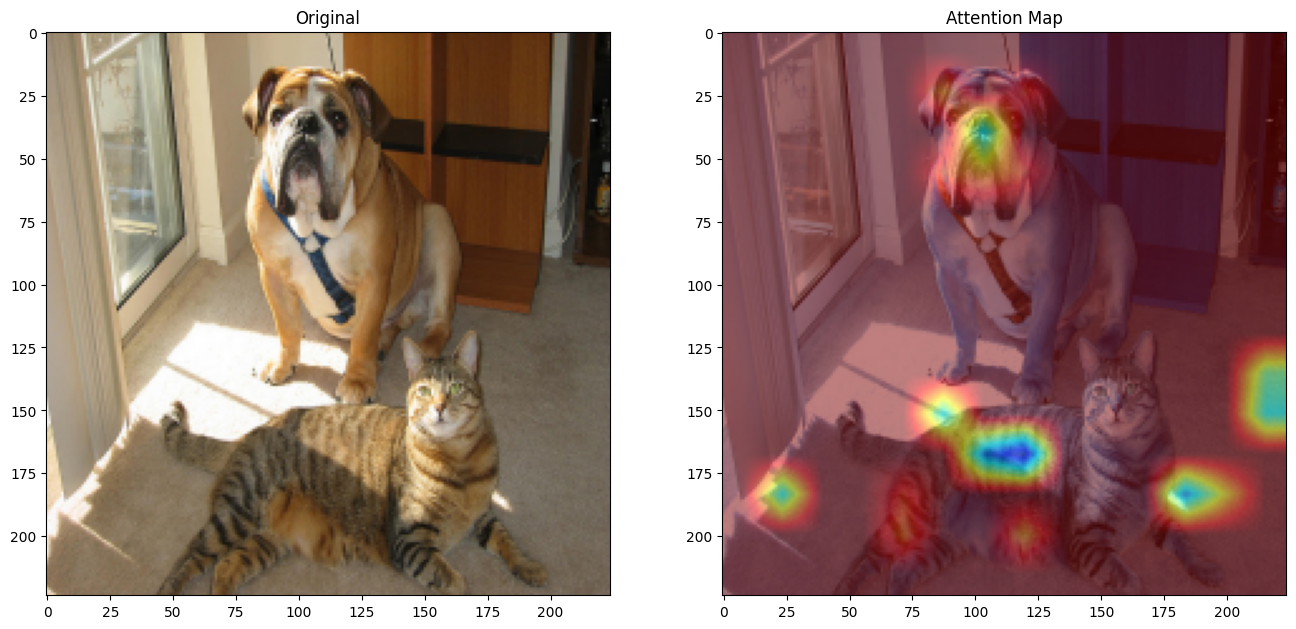

In [42]:
#@title Select the rollout strategy to be used and display results
#@markdown **Note** that for `grad_attention_rollout` passing a category index is mandatory.
rollout_strategy = "attention_flow" #@param ["attention_rollout", "grad_attention_rollout"]
category_index =  264#@param {type:"integer"}

print(f"Using {rollout_strategy}")

input_tensor  = preprocess_image("examples/both.png", transform)

if rollout_strategy == "grad_attention_rollout" and category_index < 0:
    raise Exception("Category index is mandatory when using Gradient Attention Rollout")

elif rollout_strategy == "grad_attention_rollout" and category_index > 0:
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=DISCARD_RATIO)
    mask = grad_rollout(input_tensor, category_index)
    name = "grad_rollout_{}_{:.3f}_{}.png".format(category_index,
        DISCARD_RATIO, "mean")

elif rollout_strategy == "attention_rollout":
    attention_rollout = VITAttentionRollout(model, discard_ratio=DISCARD_RATIO)
    mask = attention_rollout(input_tensor)
    name = "attention_rollout_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")
    
elif rollout_strategy == "attention_flow":
    attention_flow = VITAttentionFlow(model, discard_ratio=DISCARD_RATIO)
    mask = attention_flow(input_tensor)
    name = "attention_flow_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")

np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)

# mask = (mask - mask.min()) / (mask.max() - mask.min())
# mask = mask.clip(0.7,1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(mask)

## Attacks on the model

In [16]:
import io
import requests
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import maxflow

In [43]:
import requests
import torch.nn.functional as F
output=model(input_tensor)

LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
classes = {int(key): value for (key, value) in requests.get(LABELS_URL).json().items()}

scores = model(input_tensor)

def print_preds(scores):
    # print the predictions with their 'probabilities' from the scores
    h_x = F.softmax(scores, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()
    # output the prediction
    for i in range(0, 5):
        print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    return idx

_ = print_preds(scores)

0.266 -> ['n02108422', 'bull_mastiff']
0.062 -> ['n02108089', 'boxer']
0.039 -> ['n02123159', 'tiger_cat']
0.033 -> ['n02110958', 'pug']
0.023 -> ['n02123045', 'tabby']


In [44]:
#performing fgsm attack
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    grad_sign = torch.sign(data_grad)

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * grad_sign

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

idx = 656 #minivan
criterion = nn.CrossEntropyLoss()
input_tensor.requires_grad = True
scores = model(input_tensor)
target = torch.tensor([idx])

#TODO: compute the loss to backpropagate
loss = criterion(scores, target)
loss.backward()

_ = print_preds(scores)

0.266 -> ['n02108422', 'bull_mastiff']
0.062 -> ['n02108089', 'boxer']
0.039 -> ['n02123159', 'tiger_cat']
0.033 -> ['n02110958', 'pug']
0.023 -> ['n02123045', 'tabby']


0.025 -> ['n02088364', 'beagle']
0.019 -> ['n02108089', 'boxer']
0.017 -> ['n02123045', 'tabby']
0.016 -> ['n02123159', 'tiger_cat']
0.016 -> ['n02107574', 'Greater_Swiss_Mountain_dog']


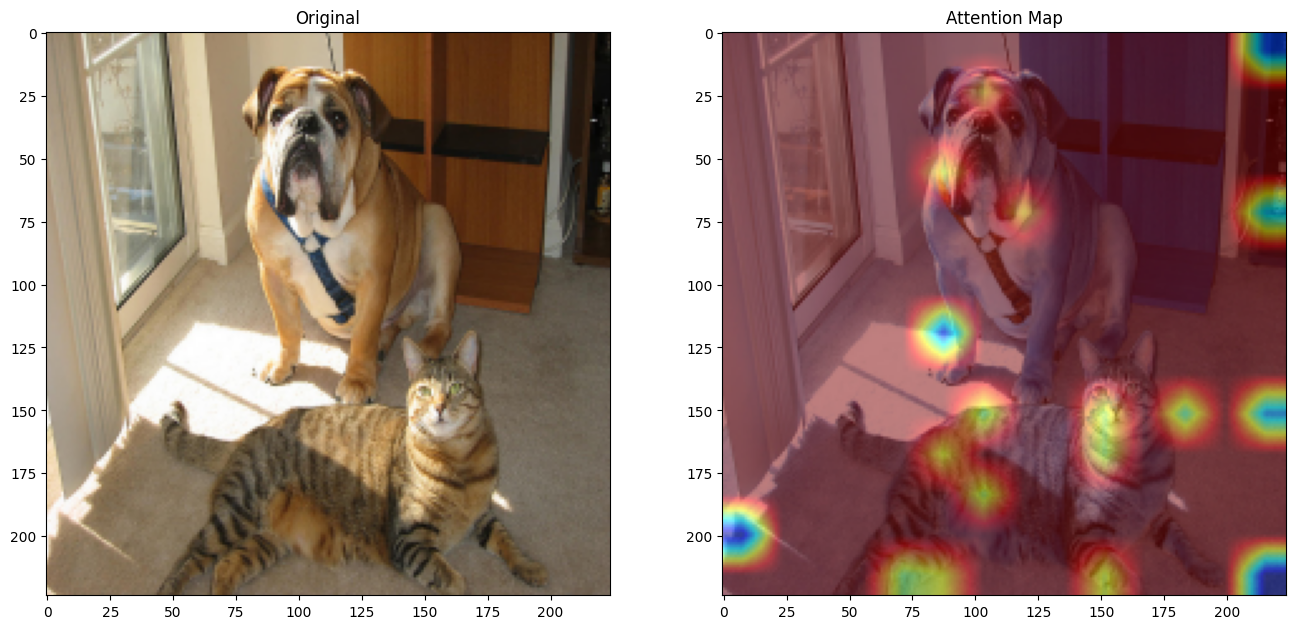

In [45]:
epsilon = 0.05
x_att=fgsm_attack(input_tensor, epsilon, input_tensor.grad.data)
scores = model(x_att)
_ = print_preds(scores)

#performing fgsm attack on the
input_tensor  = x_att

if rollout_strategy == "grad_attention_rollout" and category_index < 0:
    raise Exception("Category index is mandatory when using Gradient Attention Rollout")

elif rollout_strategy == "grad_attention_rollout" and category_index > 0:
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=DISCARD_RATIO)
    mask = grad_rollout(input_tensor, category_index)
    name = "grad_rollout_{}_{:.3f}_{}.png".format(category_index,
        DISCARD_RATIO, "mean")

elif rollout_strategy == "attention_rollout":
    attention_rollout = VITAttentionRollout(model, discard_ratio=DISCARD_RATIO)
    mask = attention_rollout(input_tensor)
    name = "attention_rollout_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")
    
elif rollout_strategy == "attention_flow":
    attention_flow = VITAttentionFlow(model, discard_ratio=DISCARD_RATIO)
    mask = attention_flow(input_tensor)
    name = "attention_flow_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")

np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)

# mask = (mask - mask.min()) / (mask.max() - mask.min())
# mask = mask.clip(0.7,1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(mask)


Carlini and Wagner) Attack:

In [52]:
def cw_attack(image, model, targeted=False, c=1e-4, kappa=0, max_iter=1000, learning_rate=0.01):
    def softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def f(x):
        return softmax(model(x)[0])

    def loss(x, labels, targeted):
        if targeted:
            return -np.log(f(x)[labels])
        else:
            return -np.log(1 - f(x)[labels])

    image = np.expand_dims(image, axis=0)

    w = np.zeros_like(image)
    w[:] = np.random.randn(*w.shape)

    for iteration in range(max_iter):
        w += learning_rate * np.sign(w)

        w_pert = image + (1 + np.tanh(w)) / 2.0 * (1 - image)

        if targeted:
            target_label = (kappa + 1) % 10
            l = loss(w_pert, target_label, True)
        else:
            l = loss(w_pert, kappa, False)

        grad = np.gradient(l)

        if l < 0.0001:
            break

    adv = w_pert

    return adv
